In [6]:
machine = 'mac'
machine = 'magny'

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *
%matplotlib inline

level   : 4
halo    : 24
snapnr  : 90
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 21.11937714  20.39230919  22.20462799]
Found 1227647 stars.
Rotated pos.
Rotated vel.

galrad  : 0.017964252829551698
redshift: 0.6214287452425136
time    : 0.616740021992414
center  : [ 0.  0.  0.]



/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



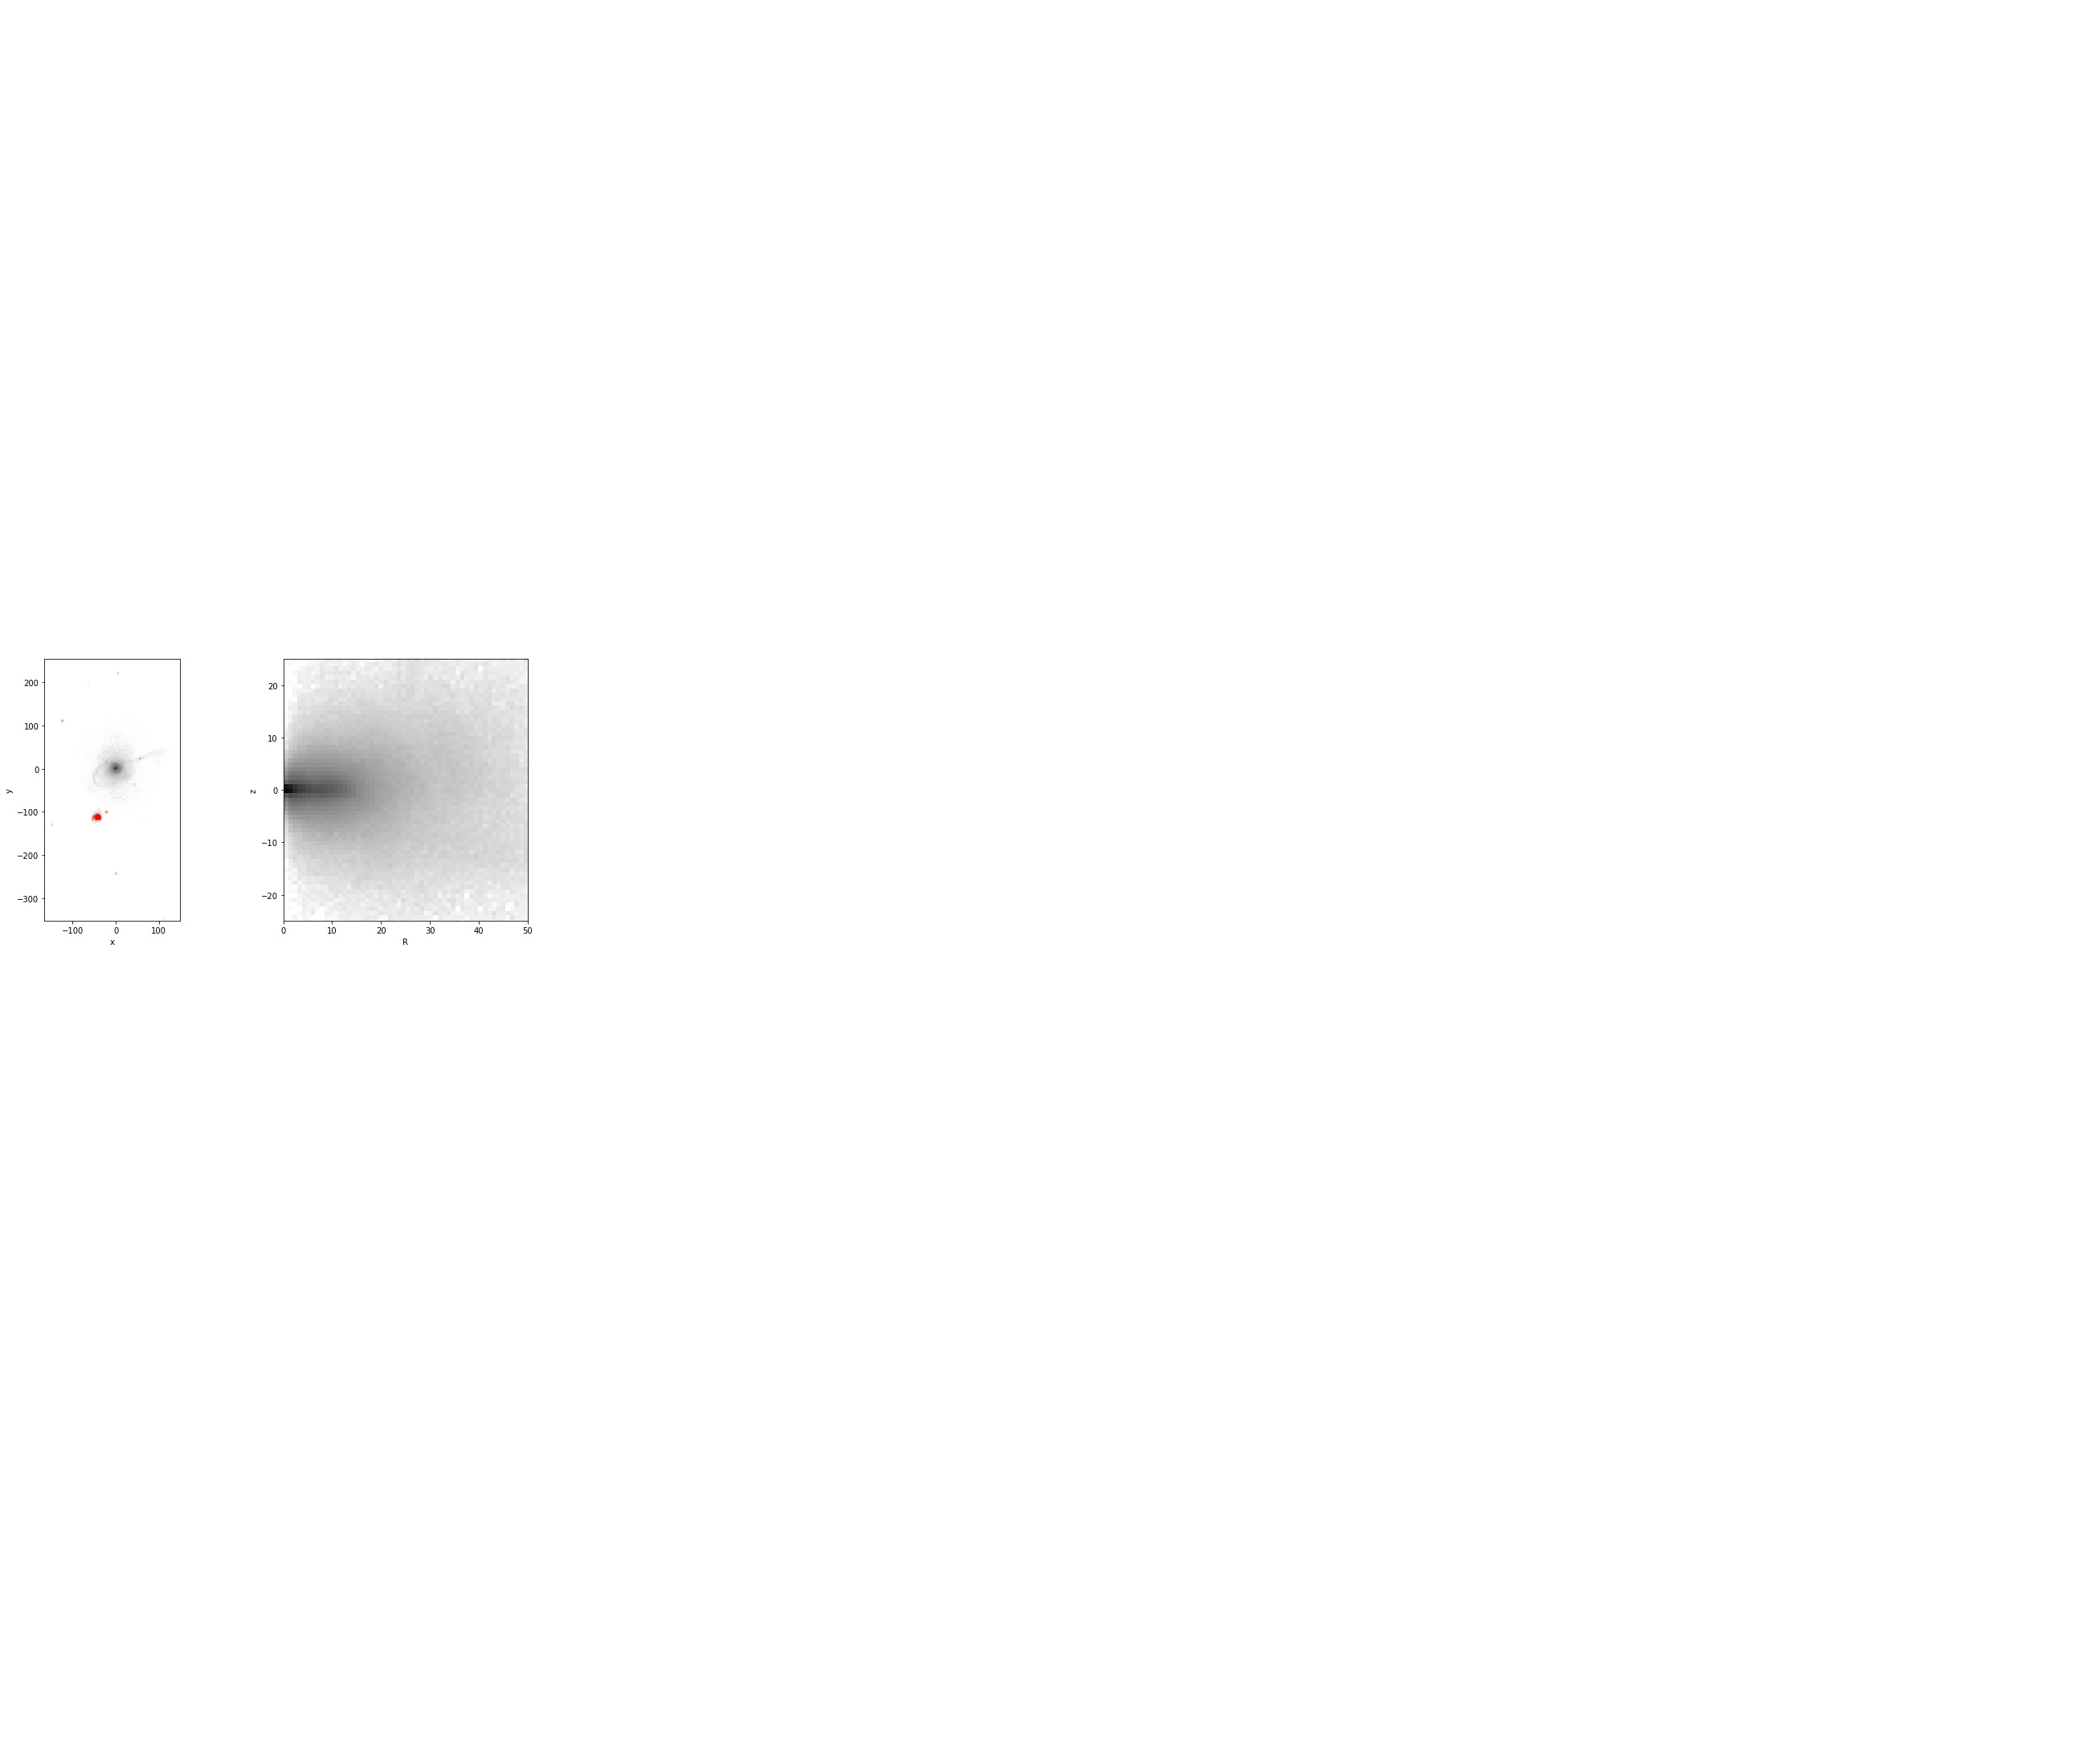

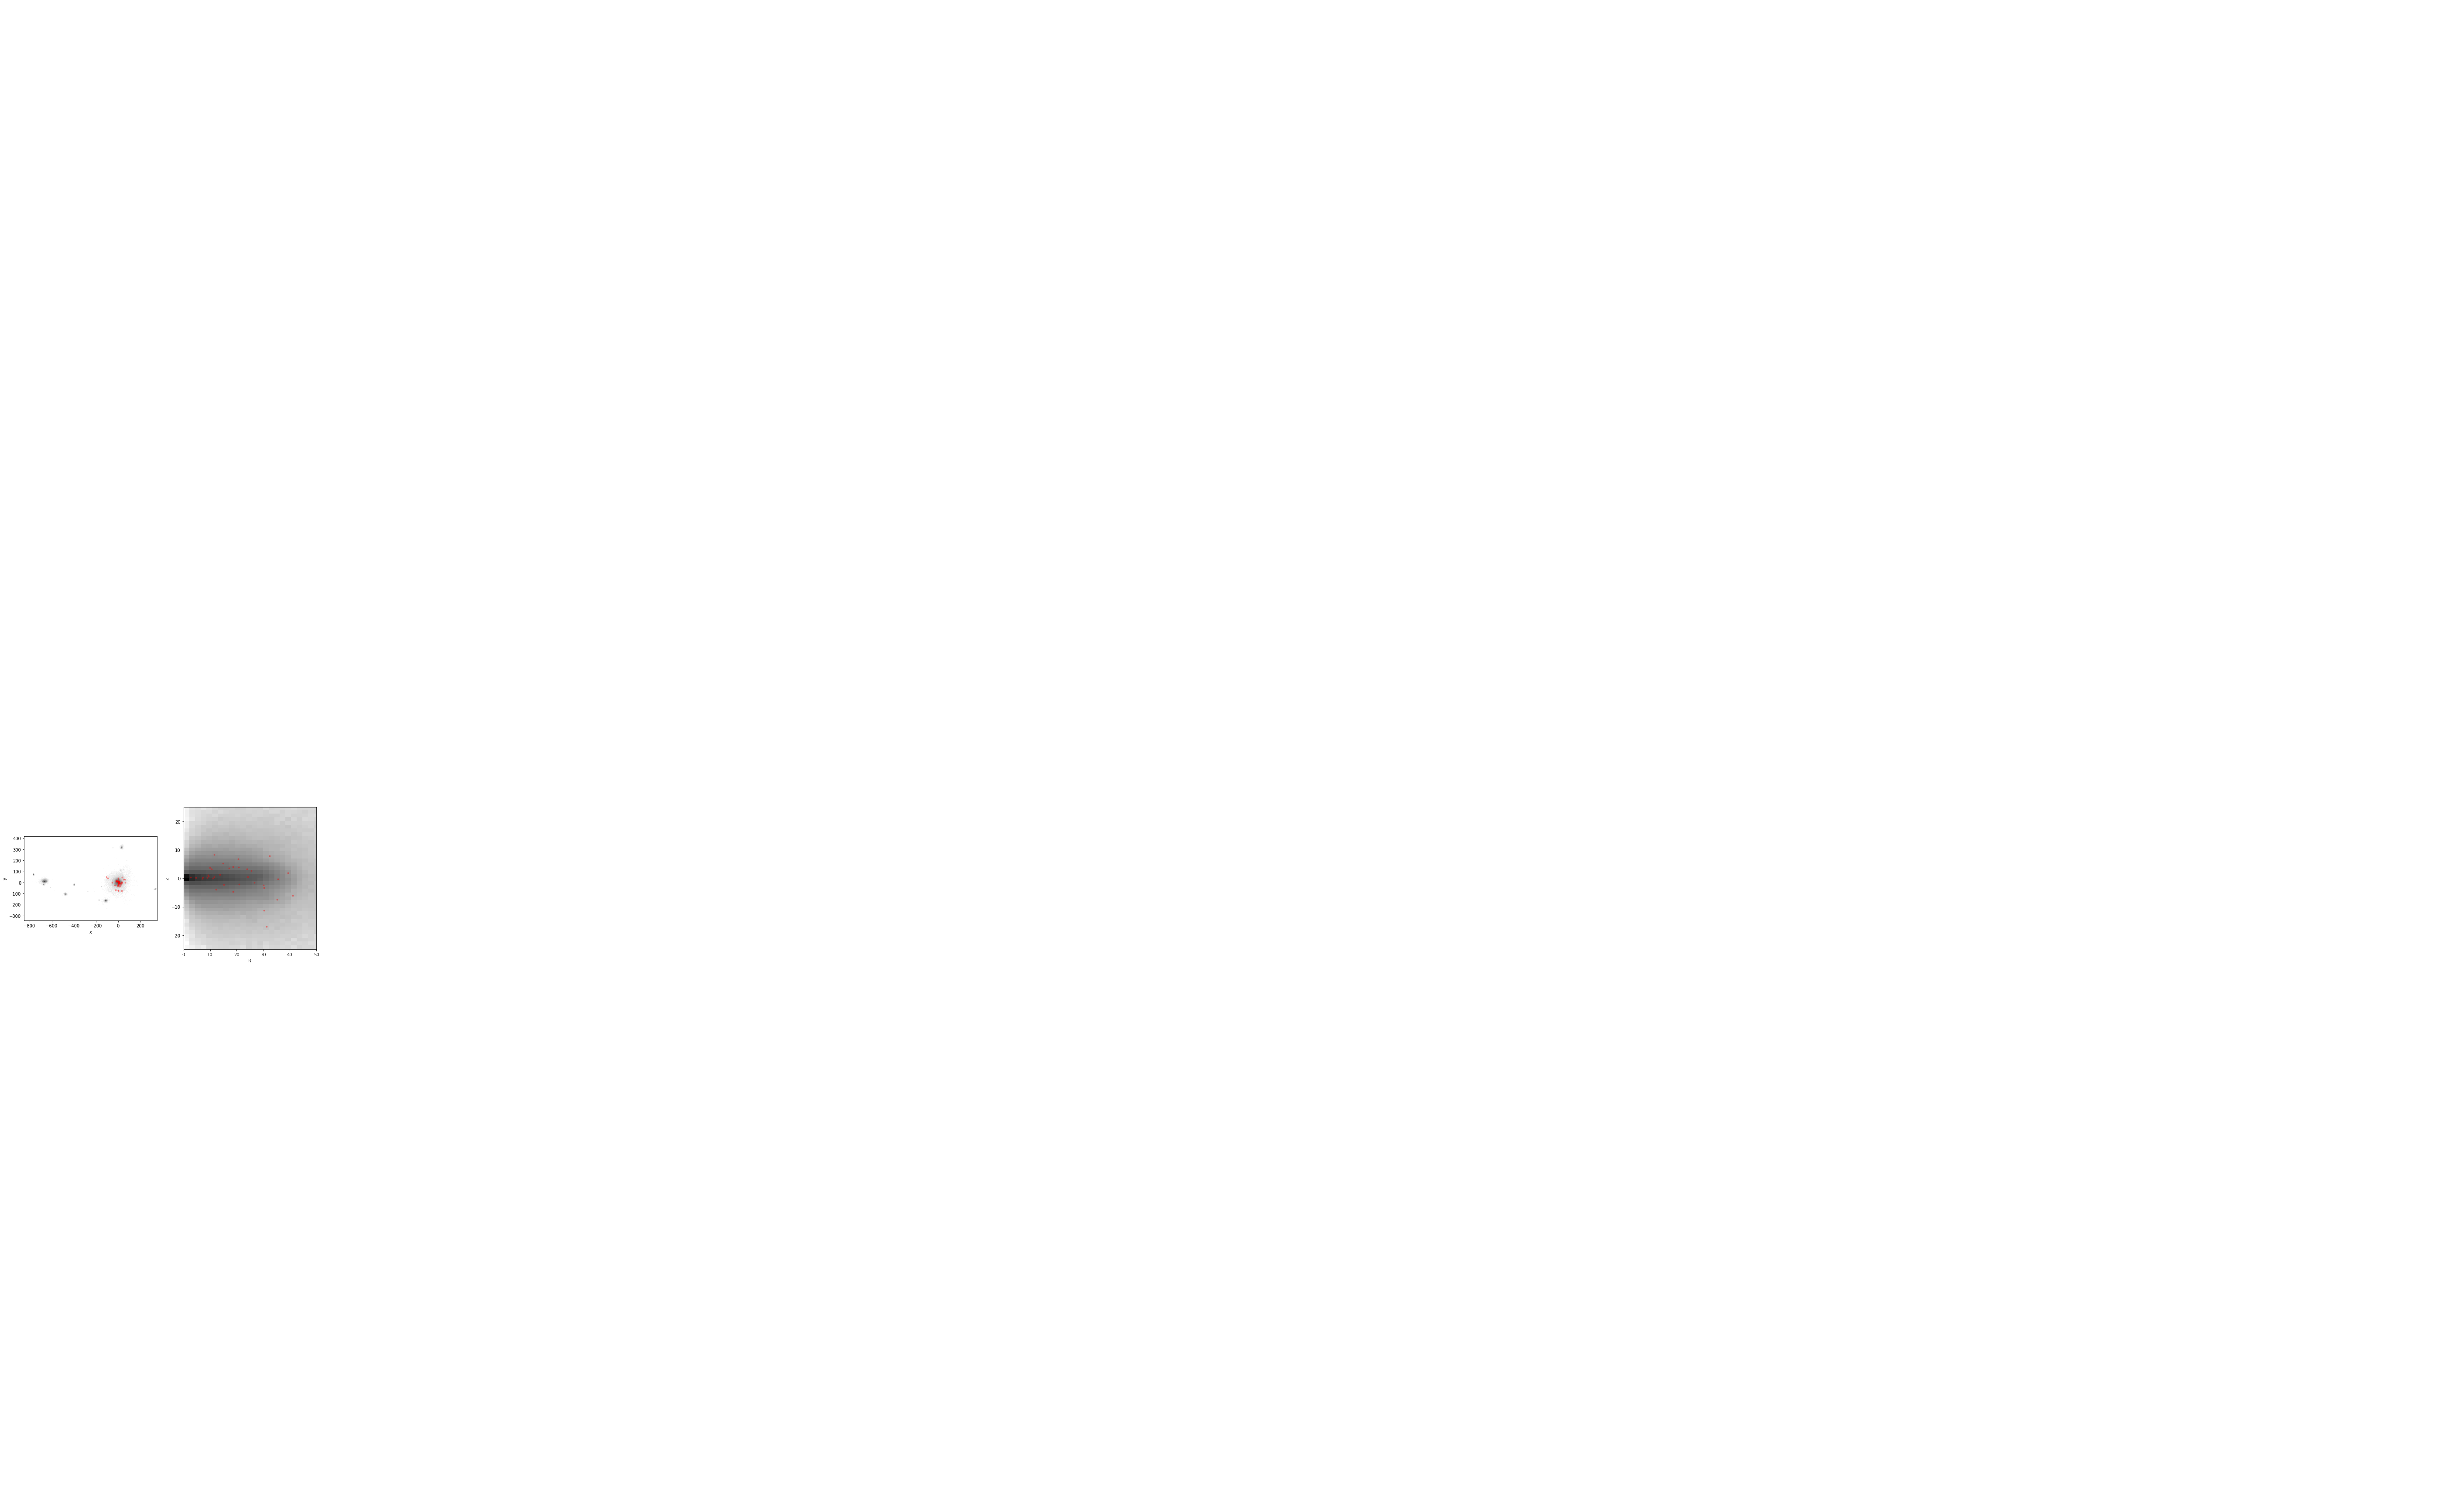

In [23]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    '''
    s_main, sf_main =  eat_snap_and_fof(level, halo_number, 127, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 
    s_main.data['gmet'] = np.maximum( s_main.data['gmet'], 1e-40 )
    istars, = np.where( (s.type == 4) & (s.halo == 0) )
    (x_main_Mpc, y_main_Mpc, z_main_Mpc), (vx_main_Mpc, vy_main_Mpc, vz_main_Mpc), rxyz_main_Mpc, rxy_main_Mpc = get_cartesian_vectors(s, sf, istars)
    '''
    for snapnr in [90,127]:
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        

        istarssub, = np.where( (s.type == 4) & (s.halo == 0) & (s.subhalo == 1) )
        istarssubsample = np.random.choice(istarssub, 50)
        if j == 0:
            ids_halo1 = s.id[istarssubsample]
        j +=1
        istars, = np.where( (s.type == 4) & (s.halo == 0) )
        (x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)
        #xt, yt, zt = x[im], y[im], z[im]
        
        
        subhalomask = np.isin(s.id[istars], ids_halo1)
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
  
        ax1.hist2d(1000*x, 1000*y, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        ax1.plot(1000*x[subhalomask], 1000*y[subhalomask], 'r.', alpha = 0.3)
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        ax1.set_aspect('equal')
        ax2.hist2d(1000*rxy, 1000*z, bins=401, norm=matplotlib.colors.LogNorm(), cmap = 'Greys')
        ax2.plot(1000*rxy[subhalomask], 1000*z[subhalomask], 'r.', alpha = 0.3)
        ax2.set_xlabel("R")
        ax2.set_ylabel("z")
        ax2.set_xlim(0,50)
        ax2.set_ylim(-25,25)
        #ax2.set_aspect('equal')
        fig.show()

